# Comparing axis-aligned decision tree versus oblique decision tree on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using `2` more custom simulation datasets: `sparse_parity`, `trunk` along with other simulation datasets from scikit-learn datasets module

## Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


## Import packages

In [2]:
import sklearn
from sklearn.tree import DecisionTreeClassifier, ObliqueDecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_low_rank_matrix, make_multilabel_classification, \
                            make_circles, make_moons, make_hastie_10_2, make_blobs, \
                            make_sparse_uncorrelated, make_gaussian_quantiles
from sklearn.model_selection import RepeatedKFold, cross_validate

from datetime import datetime
from tqdm import tqdm
import itertools
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-05-26'

#### Generating custom simulation datasets

In [4]:
def sparse_parity(n_samples, p=20, p_star=3, noise=None, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

def trunk(n_samples, p=10, noise=None, random_seed=None, **kwarg):

    if random_seed: 
        np.random.seed(random_seed)

    mu_1 = np.array([1/i for i in range(1,p+1)])
    mu_0 = -1 * mu_1

    cov = np.identity(p)

    X = np.vstack((
        np.random.multivariate_normal(mu_0, cov, int(n_samples/2)),
        np.random.multivariate_normal(mu_1, cov, int(n_samples/2))
        ))

    y = np.concatenate((
        np.zeros(int(n_samples/2)),
        np.ones(int(n_samples/2))
        ))

    return X, y

In [5]:
def get_sample(func, n, m=None, o=None):
    k = {}

    if m: k['noise'] = m
    if o: k['n_features'] = o

    k['n_samples'] = n
    k['random_state'] = random_state # random_state for classifiers

    X, y = func(**k)

    return X, y

def get_scores(X, y, max_features, max_depth, random_state, n_cv=5, n_repeats=10):

    clfs = [
        RandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state)
    ]

    tmp = []

    for i, clf in enumerate(clfs):

        if i == 0 and isinstance(max_features, int):
            if max_features > X.shape[1]:
                tmp.append(np.zeros(n_cv * n_repeats))
                continue

        cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=random_state)
        test_score = cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring='accuracy')
        
        tmp.append(
            test_score['test_score']
        )

    # print(f'max_feature: {max_features} | max_depth: {max_depth}')

    return tmp

In [6]:
def run_experiment(n_repeat=10):
    n_samples = [100, 1000]
    max_depths = [1,2,5,10, None]
    accs = []
    
    clf_kwarg = {
        'max_features': None,
        'max_depth': None,
        'random_state': random_state
    }

    for n_sample in tqdm(n_samples):
        data_args = [
            # name of dataset, function, n_sample, noise, n_features
            ['sparse_parity', sparse_parity, n_sample],
            ['trunk', trunk, n_sample],
            ['make_gaussian_quantiles', make_gaussian_quantiles, n_sample, None, 10], #noise, n_features
            ['make_circles', make_circles, n_sample, 0.3], #noise
            ['make_moons', make_moons, n_sample, 0.4],
            ['make_hastie_10_2', make_hastie_10_2, n_sample]
        ]

        for arg in data_args:

            X, y = get_sample(*arg[1:])
            
            for max_feature in [1, 'sqrt', X.shape[1]*2, X.shape[1]*3]: #max_features
                for max_depth in max_depths:
                    clf_kwarg['max_features'] = max_feature
                    clf_kwarg['max_depth'] = max_depth

                    acc = get_scores(X, y, **clf_kwarg)
                    accs.append([arg[0], n_sample, n_repeat, max_feature, max_depth, random_state] + acc)

    df = pd.DataFrame(accs, columns=['dataset', 'n_sample', 'n_repeat', 'max_feature', 'max_depth', 'random_state', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    return df

In [7]:
df = run_experiment()

100%|██████████| 2/2 [35:50<00:00, 1075.46s/it]


In [8]:
df

,dataset,n_sample,n_repeat,max_feature,max_depth,random_state,RF,OF,delta
0,sparse_parity,100,10,1,1.0,123456,"[0.55, 0.6, 0.45, 0.5, 0.35, 0.4, 0.45, 0.45, ...","[0.55, 0.5, 0.5, 0.5, 0.35, 0.4, 0.5, 0.4, 0.3...","[0.0, -0.09999999999999998, 0.0499999999999999..."
1,sparse_parity,100,10,1,2.0,123456,"[0.45, 0.6, 0.45, 0.4, 0.3, 0.4, 0.35, 0.4, 0....","[0.4, 0.5, 0.45, 0.4, 0.3, 0.3, 0.45, 0.4, 0.2...","[-0.04999999999999999, -0.09999999999999998, 0..."
2,sparse_parity,100,10,1,5.0,123456,"[0.55, 0.7, 0.4, 0.45, 0.35, 0.3, 0.25, 0.5, 0...","[0.45, 0.5, 0.4, 0.5, 0.4, 0.45, 0.4, 0.45, 0....","[-0.10000000000000003, -0.19999999999999996, 0..."
3,sparse_parity,100,10,1,10.0,123456,"[0.5, 0.6, 0.35, 0.4, 0.3, 0.35, 0.45, 0.45, 0...","[0.55, 0.5, 0.35, 0.5, 0.45, 0.5, 0.4, 0.45, 0...","[0.050000000000000044, -0.09999999999999998, 0..."
4,sparse_parity,100,10,1,NaN,123456,"[0.45, 0.65, 0.4, 0.5, 0.35, 0.35, 0.4, 0.4, 0...","[0.45, 0.55, 0.4, 0.5, 0.4, 0.5, 0.4, 0.4, 0.5...","[0.0, -0.09999999999999998, 0.0, 0.0, 0.050000..."
...,...,...,...,...,...,...,...,...,...
235,make_hastie_10_2,1000,10,30,1.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.755, 0.705, 0.725, 0.69, 0.71, 0.645, 0.68,...","[0.755, 0.705, 0.725, 0.69, 0.71, 0.645, 0.68,..."
236,make_hastie_10_2,1000,10,30,2.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.765, 0.73, 0.745, 0.715, 0.73, 0.735, 0.695...","[0.765, 0.73, 0.745, 0.715, 0.73, 0.735, 0.695..."
237,make_hastie_10_2,1000,10,30,5.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.805, 0.745, 0.79, 0.76, 0.79, 0.76, 0.735, ...","[0.805, 0.745, 0.79, 0.76, 0.79, 0.76, 0.735, ..."
238,make_hastie_10_2,1000,10,30,10.0,123456,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.835, 0.82, 0.825, 0.775, 0.815, 0.815, 0.77...","[0.835, 0.82, 0.825, 0.775, 0.815, 0.815, 0.77..."


In [9]:
df2 = df.copy()
df2['max_depth'] = df2.max_depth.replace(np.nan, 'inf')

In [10]:
dff2 = df2.explode(['RF', 'OF'])[['dataset', 'n_sample', 'max_feature', 'max_depth', 'RF', 'OF']].groupby(['dataset', 'n_sample', 'max_feature','max_depth']).mean()
dff2.style.background_gradient(cmap='RdBu_r', low=0, high=0, vmin=0, vmax=1)

<AxesSubplot:xlabel='dataset,n_sample,max_feature,max_depth'>

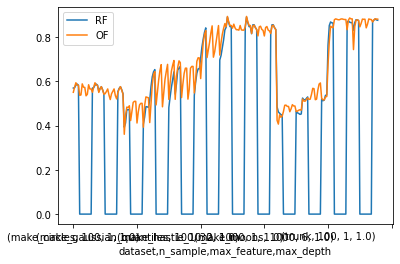

In [11]:
dff2.plot()